In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
                    
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate,GlobalMaxPool1D



In [4]:
## Reading the train and test dataframes already created
df_train = pd.read_csv('df_train.csv')

df_train.head(5)
print('Number of rows of train dataframe : {} and number of columns in train dataframe : {}'.format(df_train.shape[0],df_train.shape[1]))

Number of rows of train dataframe : 128000 and number of columns in train dataframe : 3


In [5]:
## Reading the train and test dataframes already created
df_test = pd.read_csv('df_test.csv')

df_test.head(5)
print('Number of rows of test dataframe : {} and number of columns in test dataframe : {}'.format(df_test.shape[0],df_test.shape[1]))

Number of rows of test dataframe : 32000 and number of columns in test dataframe : 3


In [6]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 51000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
X_train = df_train["question_text"].fillna("_na_").values
X_test = df_test["question_text"].fillna("_na_").values
#test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
#test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
#test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
y_train = df_train['target'].values
y_test = df_test['target'].values


In [7]:
EMBEDDING_FILE = 'wiki-news-300d-1M-subword.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [8]:
inp = Input(shape=(maxlen,))
x = layers.Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = layers.Bidirectional(layers.GRU(300, return_sequences = True))(x)
x = layers.Bidirectional(layers.GRU(300, return_sequences = True))(x)
x = layers.Bidirectional(layers.GRU(300, return_sequences = True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          15300000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 600)          1083600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 600)          1623600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 600)          1623600   
_________________________________________________________________
global_max_pooling1d (Global (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                9616  

In [9]:
model.fit(X_train,y_train,epochs=5, batch_size=128, verbose=1)

Epoch 1/5
1000/1000 [==============================] - 501s 501ms/step - loss: 0.3150 - accuracy: 0.8735
Epoch 2/5
1000/1000 [==============================] - 504s 504ms/step - loss: 0.2386 - accuracy: 0.9108
Epoch 3/5
1000/1000 [==============================] - 505s 505ms/step - loss: 0.2107 - accuracy: 0.9224
Epoch 4/5
1000/1000 [==============================] - 502s 502ms/step - loss: 0.1871 - accuracy: 0.9324
Epoch 5/5
1000/1000 [==============================] - 504s 504ms/step - loss: 0.1651 - accuracy: 0.9405


In [10]:
def line_search_f1_score(y_score, y_test):
    max_f1_score = 0
    opt_threshold = 0
    for threshold in [i*0.01 for i in range(100)]:
        y_preds = y_score > threshold
        score = f1_score(y_preds, y_test)
        if max_f1_score < score:
            max_f1_score = score
            opt_threshold = threshold
    return max_f1_score, opt_threshold

In [11]:
predictions = model.predict(X_test, verbose=1)
max_f1_score, threshold = line_search_f1_score(predictions, y_test)

1000/1000 [==============================] - 75s 75ms/step


In [12]:
print(max_f1_score,threshold)

0.8867308041386822 0.4


In [13]:
preds = [1 if x > 0.4 else 0 for x in predictions]

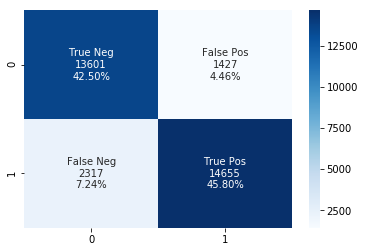

In [ ]:
cf_matrix = confusion_matrix(preds, y_test)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
clf_report = classification_report(y_test,
                                   preds,
                                   labels=[0,1],
                                   output_dict=True)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax,square = False)

In [ ]:
print(accuracy_score(preds,y_test))